## Profit based approach ##


In [1]:
#import
import pandas as pd
import math

#read our data from the 2122 season
matches= pd.read_csv("data_21.csv")


Prepare the data for the modeling, including a column with payouts if bet or not bet on  the over under market.

In [2]:
#catergorise data
matches["home_code"]= matches["HomeTeam"].astype("category").cat.codes
matches["away_code"]= matches["AwayTeam"].astype("category").cat.codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches["Day_code"] = matches["Date"].dt.dayofweek
matches['ref_code']=matches['Referee'].astype("category").cat.codes
matches['high_scoring'] = (matches['FTHG'] + matches['FTAG'] >= 3).astype(int)



In [7]:
##create a function to create a pnl row
def bet_pnl(row):
    if row['high_scoring'] == 1:
        return row['Max>2.5'] -1
    if  row['high_scoring'] == 0:
        return -1

## apply this to create a new bet_pnl column
matches['bet_pnl'] = matches.apply(lambda row: bet_pnl(row), axis=1)


In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Prepare the data as before

# Select relevant features
predictors = ['home_code', 'away_code', 'Day_code', 'ref_code', 'B365>2.5','Max>2.5']

# Split the data into predictors (X) and target (y)
X = matches[predictors]
y = matches['bet_pnl']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_scaled, y)

# Make predictions on the same data
y_pred = model.predict(X_scaled)

# Evaluate the model using mean squared error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.14728809185851063


## Test the new model ##


In [98]:
#read our new data that we will made predicitons on
matches2= pd.read_csv("season_2223.csv")

#prepare this data
matches2["home_code"]= matches2["HomeTeam"].astype("category").cat.codes
matches2["away_code"]= matches2["AwayTeam"].astype("category").cat.codes
matches2['Date'] = pd.to_datetime(matches2['Date'])
matches2["Day_code"] = matches2["Date"].dt.dayofweek
matches2['ref_code']=matches2['Referee'].astype("category").cat.codes
matches2['high_scoring'] = (matches2['FTHG'] + matches2['FTAG'] >= 3).astype(int)
matches2['bet_pnl'] = matches2.apply(lambda row: bet_pnl(row), axis=1)

#Run the model
X = matches2[predictors]
y = matches2['bet_pnl']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

predictions = model.predict(X_scaled)

In [99]:
matches2['predicted_pnl']=predictions
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(matches2['bet_pnl'],matches2 ['predicted_pnl'] )
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.9157927894736843


In [100]:
def bet_made(row):
    
    # make bets if expected to make 0.15
    if row['predicted_pnl'] >0.15:
        return row['bet_pnl']

    # dont otherwise
    if row['predicted_pnl']  <=0.15:
        return 0
    
  

matches2['applied_pnl'] = matches2.apply(lambda row: bet_made(row), axis=1)


In [101]:
matches2['applied_pnl'].sum()
totalpnl=matches2['applied_pnl'].sum()

In [102]:
totalpnl

9.86

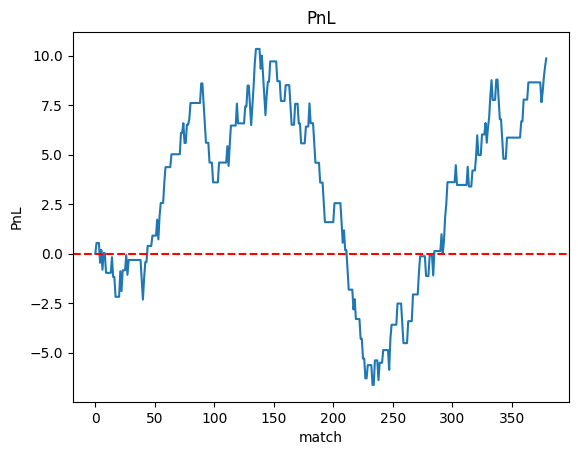

In [104]:
#get the pnl
import numpy as np
pnl_results = matches2.loc[:, 'applied_pnl'].values
pnl_cumulative=np.cumsum(pnl_results)

# plot a graph of pnl
import matplotlib.pyplot as plt
plt.plot(pnl_cumulative)
plt.xlabel('match')
plt.ylabel('PnL')
plt.title('PnL')
plt.axhline(0, color='red', linestyle='--')
plt.show()

We're now profitable. one last trick, try only betting on City because they score lots.

In [111]:
def city_bet_made(row):
    
    # make bets if expected to make 0.15
    if row['predicted_pnl'] >0.15 and row['HomeTeam'] or row['AwayTeam'] == 'Man City' :
        return row['bet_pnl']

    # dont otherwise
    if row['predicted_pnl']  <=0.15:
        return 0
    
  

matches2['applied_city_pnl'] = matches2.apply(lambda row: city_bet_made(row), axis=1)
matches2['applied_city_pnl'].sum()
totalpnl_city=matches2['applied_city_pnl'].sum()

In [112]:
totalpnl_city

6.970000000000001

nope, other stil better

In [114]:
#counting bets on teams
filtered_df = matches2[matches2['predicted_pnl'] >0.15]  # Filter the DataFrame 

filtered_df.shape[0]

148

In [117]:
percent_return=(totalpnl/148)*100
percent_return

6.662162162162162